## Notebook for numerical resolution analysis and plots of injected waveforms

In [1]:
# imports
from matplotlib import rc
import h5py
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import json
from Generate_dCS_Strain import *
from scipy.signal import argrelextrema
rc('text', usetex=True)
from scipy.optimize import fmin
import seaborn as sns

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3


In [11]:
def CutTimes(time, data, TLow, TUp): 
    """ Cut time and data to be between 
        TLow and TUp  """
    TLowIndex = np.where(time >= TLow)[0][0]
    TUpIndex = np.where(time <= TUp)[0][-1]
    time = time[TLowIndex:TUpIndex]
    data = data[TLowIndex:TUpIndex]
    return time, data

def GetPeakTimeMode(time, data): 
    """ Grab the peak time of some data """
    t_peak = time[np.argmax(np.absolute(data))]
    return t_peak

def SubtractPeakTimeMode(time, data): 
    """ Subtract the peak time of some data """
    t_peak = GetPeakTimeMode(time, data)
    return time - t_peak

def EllString(ell):
    return str(ell).replace('.','p')

def GetPSD(detector, cut = True):
    
    """ Get the PSD from the same place that megaplot.py 
        gets it from. See lines 1565 - 1569 in megaplot.py
        in the ain() method 
        
        Now if 'cut' is True, then set the PSD to 1 before
        125 Hz, which is approximately where we see a difference in the 
        waveform
        """
 
    
    f = "/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p0/dCS_0p0_mtotal_68_dist_400/BW_dCS_0p0_mtotal_68_dist_400" +  \
        "/trigtime_1126259462.410700560_0.0_0.0_0/post/signal/signal_median_PSD_" + detector + ".dat"
    freq, val = np.loadtxt(f, comments="#",usecols=([0,1]),unpack=True)
    
    if cut:
        index = np.where(freq < 125)[0]
        val[index] = 1.0
        
    return freq, val

## Plot SXS waveforms 

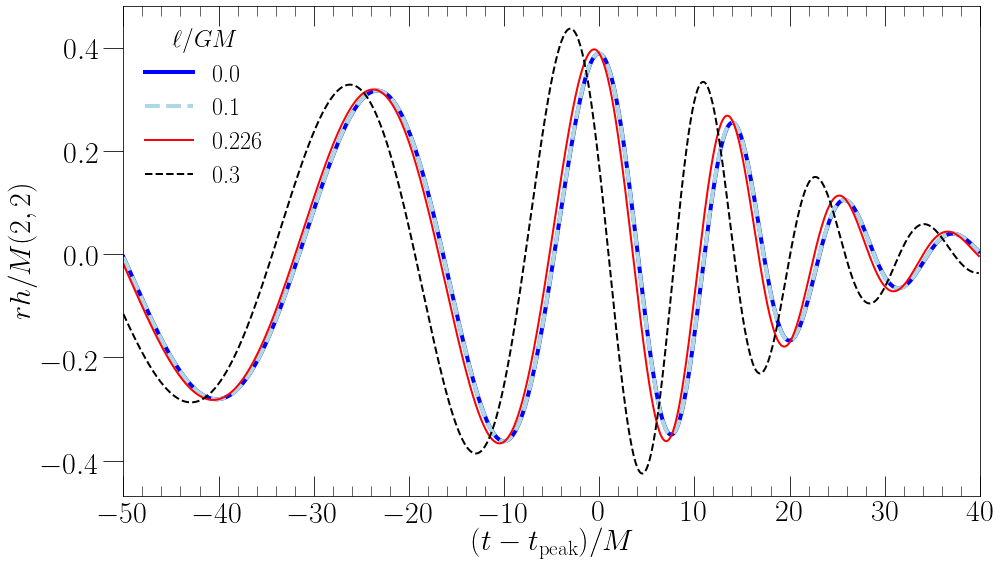

In [11]:
# Plot the strains with resolution

def PlotStrainElls(lev):
    
    f, ax = plt.subplots(1, figsize=(14,8))
    mode = (2,2)
    order = 2
    start = -50
    stop = 40
    p = "Waveforms"
    
    ells = [0.0, 0.1, 0.226, 0.3]
    cs = sns.color_palette('husl', n_colors=len(ells))
    #colors = [cs[i] for i in range(len(ells))]
    colors = ['blue', 'lightblue', 'red', 'black']
    lss = ['-','--','-', '--']
    lws = [4.0, 4.0, 2.0, 2.0]
    for ell, c, ls, lw in zip(ells, colors, lss, lws):
        time, strain = ReadExtrapolatedMode(p, "dCSModified", mode, lev, order, ell=ell)
        time = SubtractPeakTimeMode(time, strain)
        time, strain = CutTimes(time, strain, start, stop)
        ax.plot(time, np.real(strain), label=ell, lw=lw, color=c, ls=ls)

    legend = ax.legend(fontsize=24, loc='upper left', frameon=False, ncol=1, title='$\ell/GM$')
    plt.setp(legend.get_title(),fontsize=24)
    ax.set_ylabel('$rh/M (2,2)$', fontsize=30)

    ax.set_xlabel('$(t - t_\mathrm{peak})/M$', fontsize=30) 
    ax.set_xlim(start, stop)
    #ax.set_yscale('log')
    plt.tight_layout()
    plt.savefig('SXS_format.pdf')
    plt.show()     

PlotStrainElls(2)

## Plot SXS waveforms with resolution for various modes

(2, 2)


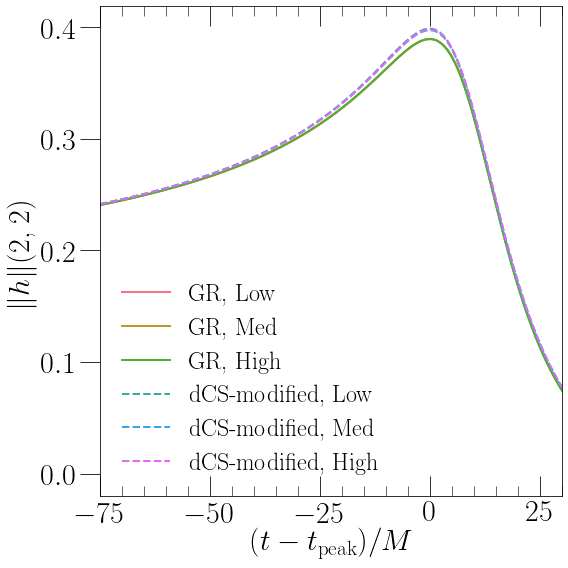

In [34]:


# Plot the SXS format strains from the simulations
def PlotSXSStrainResolutions(mode):
    
    f, ax = plt.subplots(1, figsize=(8,8))
    order = 2
    
    cs = sns.color_palette('husl', n_colors=6)
    
    i = 0
    for ell, label, ls in zip([0.0, 0.226], ['GR', 'dCS-modified'], ['-', '--']):
        
        for lev, res in zip([0,1,2], ['Low', 'Med', 'High']):
            p = "Waveforms"
            #p = "Waveforms/Lev" + str(lev)

            time, strain = ReadExtrapolatedMode(p, "dCSModified", mode, lev, order, ell=ell)
            #time, strain = ReadExtrapolatedMode(p, "DeltaStrain", mode, order, ell=ell, lev=lev)
            time = SubtractPeakTimeMode(time, strain)
            ax.plot(time, np.abs(strain), label=label+', ' + res, lw = 2.0, ls=ls, color=cs[i])
            i = i + 1
            
    legend = ax.legend(fontsize=24, loc='best', frameon=False, ncol=1)
    ax.set_ylabel(r'$\|h\|$' + str(mode), fontsize=30)
    ax.set_xlim(-75, 30)
    #ax.set_ylim(0.0, 0.45)
    ax.set_xlabel('$(t - t_\mathrm{peak})/M$', fontsize=30) 
    #ax.set_yscale('log')
    plt.tight_layout()
    plt.savefig('SXSResolutions.pdf')
    plt.show()     

#modes = [(l,m) for l in range(2,9) for m in range(-l,l+1)]
modes = [(2,2), (4,4), (3,3), (3,2), (2,1), (2,0)]
modes = [(2,2)]
for mode in modes:
    print(mode)
    PlotSXSStrainResolutions(mode)

## Frequency domain overlaps (on Bayeswave injection data)

### Helper functions

In [13]:
def GetInjectedFrequencyDomainWaveform(my_dir, detector):
    
    """ Get the injected frequency domain waveform from the same
    place that megaplot.py gets it from. See lines 541 - 543 of
    megaplot.py in plot_full_spectro() method """

    base_dir = '/home/maria.okounkova/BeyondGRAnalysis/Frames/'+my_dir+'/'+my_dir+'_mtotal_68_dist_400/BW_' + my_dir + \
        '_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/'
 
    f = base_dir + "waveforms/fourier_domain_data_" + detector + ".dat"
    freq, re, im = np.loadtxt(f, comments="#",usecols=([0,1,2]),unpack=True)
    return freq, re + 1j*im   

def InnerProduct(freq, hA, hB, PSD):

    """ Compute the inner product using the conventions of 
    https://arxiv.org/abs/2003.09456 Eq. 8"""
    
    ## Spacing in frequency
    df = freq[1] - freq[0]
    
    ## Terms inside the integral
    product = hA * np.conj(hB) / PSD 
    
    ## Compute the integral 
    total = 4.0 * np.real(np.sum(product)) * df
    return total

def ResolutionOverlap(dir1, dir2):
    
    """ Compute the overlap between the injected 
        waveform and the BW waveform for a given dCS
        coupling constant and SNR. Uses the conventions 
        of https://arxiv.org/abs/2003.09456 """
    
    ## compute the network inner products
    
    def op(w):
        return np.real(w)**2 + np.imag(w)**2
    
    total_11 = 0.0
    total_12 = 0.0
    total_22 = 0.0
    
    ## Compute the inner products summer over detectors.
    ## See Eq. 7 of https://arxiv.org/abs/2003.09456
    for detector in ["L1", "H1"]:
        
        ## Grab the psd, bw, and injected data for this detector
        freq, psd = GetPSD(ell, SNR, detector)
        
        freq, inj1 = GetInjectedFrequencyDomainWaveform(ell1, SNR, detector, res = res1)
        inj1 = op(inj1)
        freq, inj2 = GetInjectedFrequencyDomainWaveform(ell2, SNR, detector, res = res2)
        inj2 = op(inj2)
        
        total_11 = total_11 + InnerProduct(freq, inj1, inj1, psd)
        total_12 = total_12 + InnerProduct(freq, inj1, inj2, psd)
        total_22 = total_22 + InnerProduct(freq, inj2, inj2, psd)
        
    #print(total_bw_inj, total_bw_bw, total_inj_inj)
    
    ## Eq. 6 in https://arxiv.org/abs/2003.09456
    overlap = total_12 / np.sqrt(total_11  * total_22)
    return 1 - overlap


### Plotting

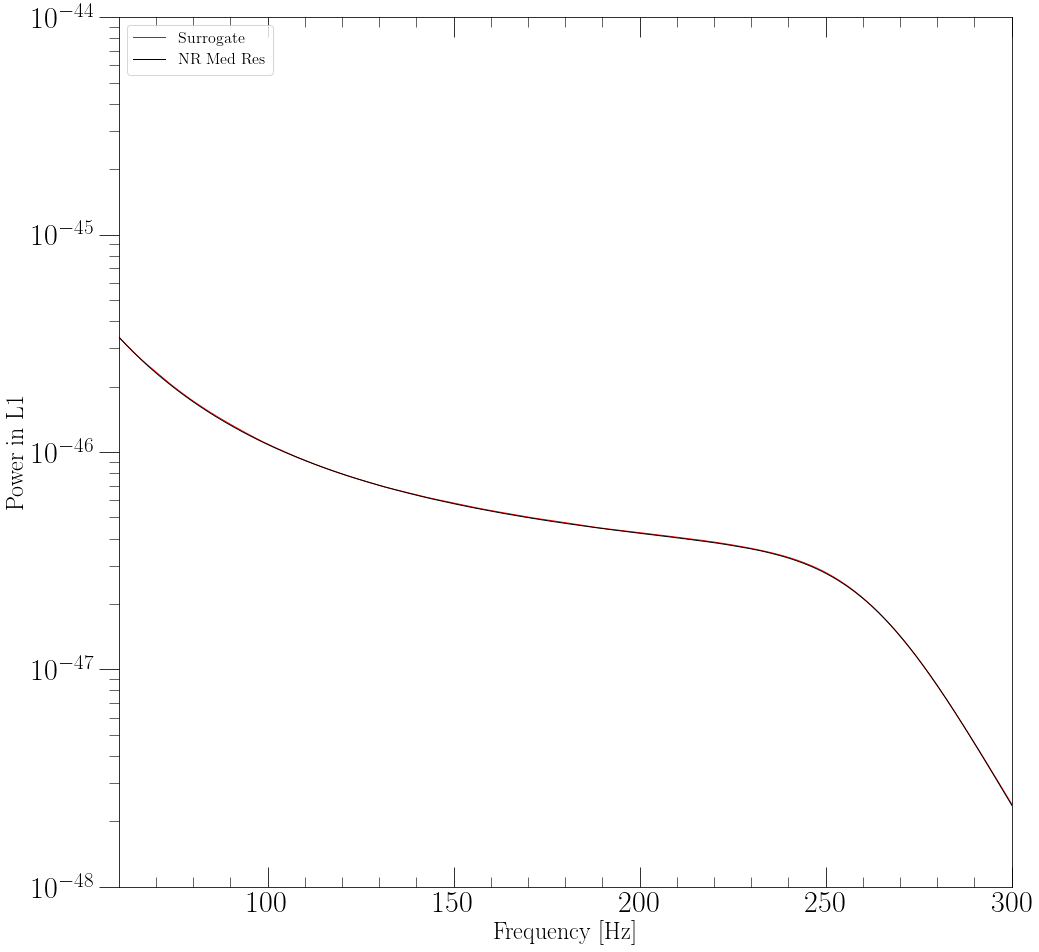

In [43]:
def FrequencyResolutionFigure():

    plt.figure(figsize=(16, 16))
    
    #label = r'$\ell$ = ' + EllinKm(ell, mass) + ', $d_L$ = ' + str(dist_mpc) + ' mpc' 
    
    detector = "L1"
    freq, psd = GetPSD(detector)
    #plt.plot(freq, psd, color='grey')
    
    def op(w):
        return np.real(w)**2 + np.imag(w)**2
    
    
    freq, inj = GetInjectedFrequencyDomainWaveform('SurrogateTest', detector)
    plt.plot(freq, op(inj), color='red', ls='-', lw=1.0, label='Surrogate') 
    
    #freq, inj = GetInjectedFrequencyDomainWaveform('dCS_0p0_Lev1', detector)
    #plt.plot(freq, op(inj), color='lightblue', ls='-', lw=10.0, label='NR Low Res') 
    
    freq, inj = GetInjectedFrequencyDomainWaveform('dCS_0p0', detector)
    plt.plot(freq, op(inj), color='black', ls='-', lw=1.0, label='NR Med Res') 
    
    #freq, inj = GetInjectedFrequencyDomainWaveform('dCS_0p0_Lev3', detector)
    #plt.plot(freq, op(inj), color='blue', ls='-', lw=1.0, label='NR Hi Res') 
    

    plt.yscale('log')
    #plt.xscale('log')
    plt.xlim(60, 300)
    plt.ylim(1e-48, 1e-44)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Power in ' + detector)
    
    plt.legend(frameon=True, fontsize=16, loc='upper left')
    plt.show()
    

FrequencyResolutionFigure()
